# Can we split the FOV and assign counts and then put this back together into a PA distribution

In [1]:

import ctypes
import ctypes.util
import os
from optparse import OptionParser
import time
import re

import matplotlib.pyplot as plt
import numpy as np
import spacepy.toolbox as tb
import spacepy.datamodel as dm
import spacepy.pycdf as pycdf
import spacepy.plot as spp

%matplotlib inline



This unreleased version of SpacePy is not supported by the SpacePy team.


/Users/blarsen/miniconda3/envs/python3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [71]:
N_SECTORS = 16

This is the C code that did the cals for all the plots below, it has been changed so I captured it here

In [2]:
from make_HOPE_PA_tags_rel04 import extract_date_string, L1arg, Barg, EventTimer
from make_HOPE_PA_tags_rel04 import makeFullTimes_Ele, makeFullTimes_Ion, interpolateB

# from pixel_matching_rel04 import resp_2d

from split_FOV_to_PA_PHI import compute_PA, setup_lib

In [122]:
# this is the version for (time, vars, n_fov)
def make_plots(ans):
    fig = plt.figure(figsize=(25,6))
    ax1 = fig.add_subplot(131)
    print(ans.shape)
    for v in ans:
        print(v.shape, v[0].shape, )
        sc = ax1.scatter(np.arange(len(v[0])), v[0], c=v[2])
    ax1.set_xlabel('Sample')
    ax1.set_ylabel('PA')
    ax1.set_yticks(np.arange(0, 181, 30))
    ax1.set_ylim((-5, 185))


    ax2 = fig.add_subplot(132)
#     ax2.scatter(np.arange(len(ans[:,0].flat)), ans[:,1].flat, c=ans[:,2].flat)
    for v in ans:
        sc = ax2.scatter(np.arange(len(v[1])), v[1], c=v[2])
    ax2.set_xlabel('Sample')
    ax2.set_ylabel('PHI')
    ax2.set_yticks(np.arange(0, 361, 30))
    ax2.set_ylim((-5, 365))

    ax3 = fig.add_subplot(133)
    for v in ans:
        sc = ax3.scatter(v[0], v[1], c=v[2])
    ax3.set_xlabel('PA')
    ax3.set_ylabel('PHI')
    ax3.set_xlim((-5, 185))
    ax3.set_ylim((-5, 365))
    ax3.set_xticks(np.arange(0, 181, 30))
    spp.timestamp()

    cb = plt.colorbar(sc)
    cb.set_label('Counts')
    

# this is the version for (index, vars)
def make_plots2(ans):
    fig = plt.figure(figsize=(25,6))
    ax1 = fig.add_subplot(131)
    print(ans.shape)
    sc = ax1.scatter(np.arange(len(ans)), ans[:,0], c=ans[:,2])
    ax1.set_xlabel('Sample')
    ax1.set_ylabel('PA')
    ax1.set_yticks(np.arange(0, 181, 30))
    ax1.set_ylim((-5, 185))


    ax2 = fig.add_subplot(132)
    sc = ax2.scatter(np.arange(len(ans)), ans[:,1], c=ans[:,2])
    ax2.set_xlabel('Sample')
    ax2.set_ylabel('PHI')
    ax2.set_yticks(np.arange(0, 361, 30))
    ax2.set_ylim((-5, 365))

    ax3 = fig.add_subplot(133)
    sc = ax3.scatter(ans[:,0], ans[:,1], c=ans[:,2])
    ax3.set_xlabel('PA')
    ax3.set_ylabel('PHI')
    ax3.set_xlim((-5, 185))
    ax3.set_ylim((-5, 365))
    ax3.set_xticks(np.arange(0, 181, 30))
    spp.timestamp()

    cb = plt.colorbar(sc)
    cb.set_label('Counts')
    

    

In [4]:

args = ['~/Downloads/rbspa_ect-hope-sci-L1_20150101_v2.1.0.cdf',
        '~/Downloads/rbsp-a_magnetometer_uvw_emfisis-L2_20150101_v1.6.1.cdf',
        'rbspa_rel04_ect-hope-PAtags-L3_20150101_v1.0.0.cdf']
outfile = args[-1]
date_string = extract_date_string(outfile)
L1infile, sc1 = L1arg(args[:-1])
Binfile, scB = Barg(args[:-1], date_string)
assert (np.asarray([sc1, scB]) == sc1).all()
lib, libname = setup_lib()

for f in (L1infile, Binfile, outfile, libname):
    print(os.path.isfile(os.path.expanduser(f)))

if os.path.isfile(outfile):
    os.remove(outfile)

Time1 = time.time()
# Open the CDF files
L1cdf = pycdf.CDF(L1infile)
Bcdf = pycdf.CDF(Binfile)
Time1 = EventTimer('CDFs open', Time1)  # time

TaggedData = dm.SpaceData()
makeFullTimes_Ele(L1cdf, TaggedData)
Time1 = EventTimer('Full times computed electrons', Time1)  # time
makeFullTimes_Ion(L1cdf, TaggedData)
Time1 = EventTimer('Full times computed ions', Time1)  # time

magInterp_Ele, magInterp_Ion = interpolateB(TaggedData, Bcdf, lib)
Time1 = EventTimer('Magnetometer interpolated', Time1)  # time

print('TaggedData')
TaggedData.tree(verbose=True)


True
True
False
True
2.83 CDFs open
0.63 Full times computed electrons
0.62 Full times computed ions
1.30 Magnetometer read from disk
0.09 Measurement fractions computed
0.90 Slerp finished
0.12 Measurement fractions computed
0.72 Slerp finished
3.15 Magnetometer interpolated
TaggedData
+
|____Epoch_Ele (spacepy.datamodel.dmarray (4143,))
|____Epoch_Ele_FRAME_subtime (numpy.ndarray (16, 72))
|____Epoch_Ion (spacepy.datamodel.dmarray (3469,))
|____Epoch_Ion_FRAME_subtime (numpy.ndarray (16, 72))
|____Full_times_Ele (numpy.ndarray (4143, 16, 72))
|____Full_times_Ion (numpy.ndarray (3469, 16, 72))


# Sector 1 for 2 spins 

In [15]:
t_ind = 100
sector = 1
energy = 32

ar = np.arange(100, 102, 1)

ans = np.empty((len(ar), 4, np.product((11-1, 13-1)) ), dtype=float)
ans.fill(0)

tb.progressbar(0,1,len(ar))
for ii, t_ind in enumerate(ar):
    tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])

    tb.progressbar(ii+1,1,len(ar), text=tm.isoformat())

    PA, PHI, counts, weights = compute_PA(100, magInterp_Ele[t_ind, sector, energy], lib, 
                                          polar_range=(-3.5, 3.5), azi_range=(-4, 4),
                                          n_polar=11, n_azi=13)
    ans[ii] += np.vstack((PA, PHI, counts, weights))

    
    
    
print(ans.shape) # this is (time, vars, n_fov)
print(np.vstack((PA, PHI, counts, weights)).shape)
print(ans[:,:,0])
# print('PA', PA.shape)
# print('PHI', PHI.shape)
# print('counts', counts.shape)
# print('weights', weights.shape)


2015-01-01T00:35:46.389000 ...100%

(2, 4, 120)
(4, 120)
[[  5.02439270e+01   1.96341837e+02   2.72086280e-01   2.72086280e-03]
 [  7.33675562e+01   1.83790795e+02   2.72086280e-01   2.72086280e-03]]


[  5.02439270e+01   1.96341837e+02   2.72086280e-01   2.72086280e-03]
(2, 4, 120)
(4, 120) (120,)
(4, 120) (120,)


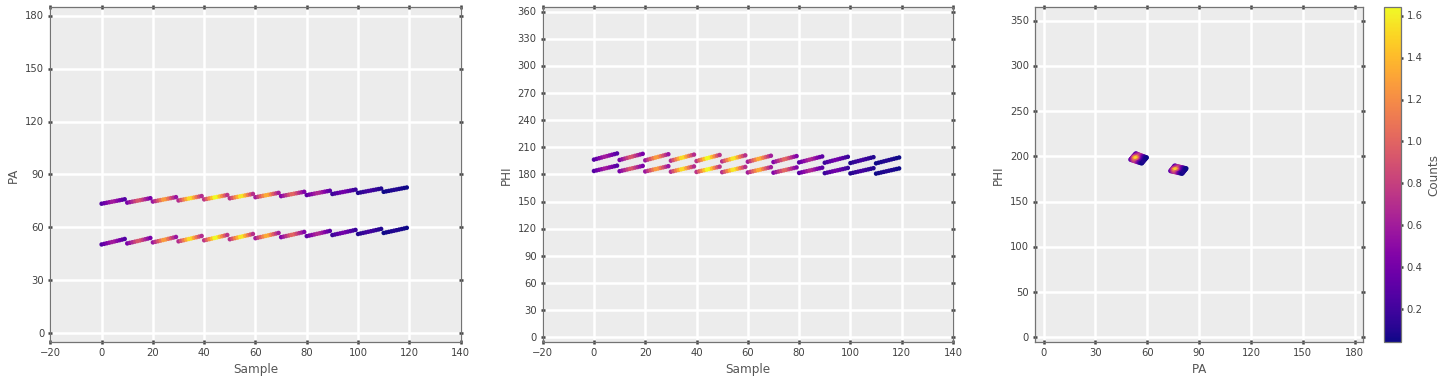

In [8]:
print(ans[0,:,0])
make_plots(ans)


2015-01-01T00:38:25.265000 ...13%(10, 4, 120)
(10, 4, 120)
(4, 120) (120,)
(4, 120) (120,)
(4, 120) (120,)
(4, 120) (120,)
(4, 120) (120,)
(4, 120) (120,)
(4, 120) (120,)
(4, 120) (120,)
(4, 120) (120,)
(4, 120) (120,)


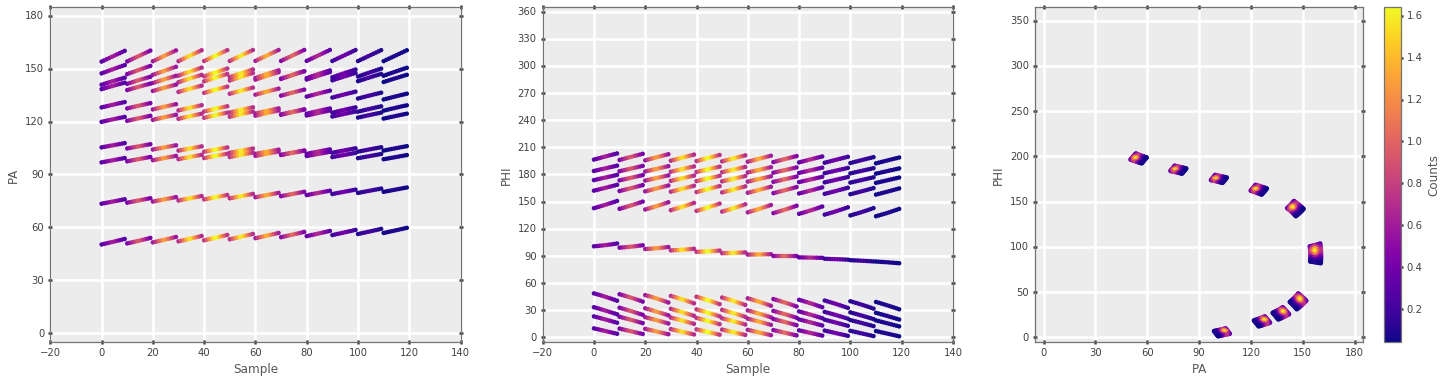

In [9]:
t_ind = 100
sector = 1
energy = 32

ar = np.arange(100, 110, 1)

ans = np.empty((len(ar), 4, np.product((11-1, 13-1)) ), dtype=float)
ans.fill(0)

tb.progressbar(0,1,len(ar))
for ii, t_ind in enumerate(ar):
    tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])

    tb.progressbar(ii+1,1,len(np.arange(100, 175, 1)), text=tm.isoformat())

    PA, PHI, counts, weights = compute_PA(100, magInterp_Ele[t_ind, sector, energy], lib, 
                                          polar_range=(-3.5, 3.5), azi_range=(-4, 4),
                                          n_polar=11, n_azi=13)
    ans[ii] += np.vstack((PA, PHI, counts, weights))

    
    
    
print(ans.shape)    # this is (time, vars, n_fov)

make_plots(ans)

# One time, 16 sectors

experiment with the output dimensions, above is (time, vars, n_fov)
## (index, vars)
this just means you run this over the time frame you want and have an array per pixel

ans.shape (1920, 4)
2015-01-01T00:35:23.692000 ...0%ans.shape (1920, 4)
(1920, 4)


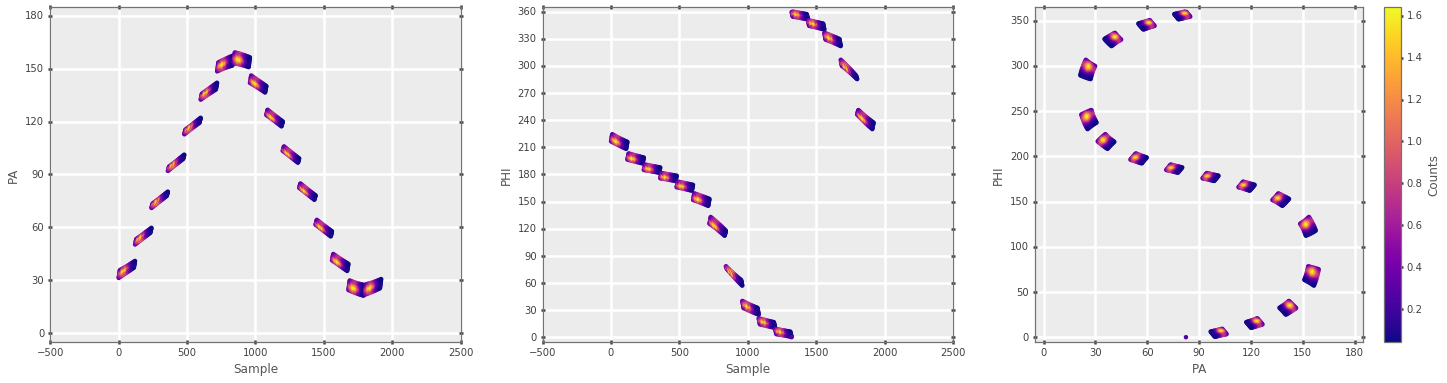

In [106]:
t_ind = 100
energy = 32

t_inds = np.arange(100, 101, 1)

len_times = len(t_inds)

t_len = np.product((len_times, N_SECTORS, 11-1, 13-1))

ans = np.empty((t_len, 4), dtype=float)
ans.fill(0)

print('ans.shape', ans.shape)  # this is (index, vars)


ans = [] # TODO figure out how to index this right

counter = 0
tb.progressbar(0,1,t_len)
for ii, t_ind in enumerate(t_inds):
    tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])
    tb.progressbar(counter,1, t_len, text=tm.isoformat())
    for jj, s_ind in enumerate(np.arange(16)):


        PA, PHI, counts, weights = compute_PA(100, magInterp_Ele[t_ind, s_ind, energy], lib, 
                                              polar_range=(-3.5, 3.5), azi_range=(-4, 4),
                                              n_polar=11, n_azi=13)
        if counter == 0:
            ans = np.vstack((PA, PHI, counts, weights)).T
        else:
            ans = np.vstack((ans, np.vstack((PA, PHI, counts, weights)).T))
            
        counter += 1


ans = np.asarray(ans)
        
    
print('ans.shape', ans.shape)  # this is (index, vars)


make_plots2(ans)
# make_plots(ans)
# ans = np.vstack((PA_out, PHI_out, ans[:,0,:], ans[:,1,:]))
# print('PA', PA.shape)
# print('PHI', PHI.shape)
# print('counts', counts.shape)
# print('weights', weights.shape)


# 10 times, 16 sectors



ans.shape (21120, 4)
2015-01-01T00:38:47.961000 ...1009%ans.shape (21120, 4)
(21120, 4)


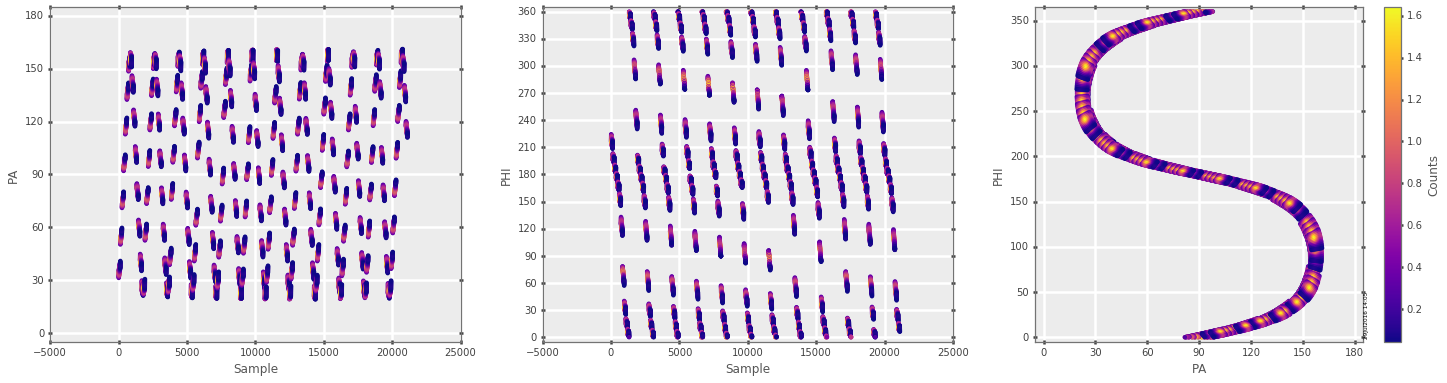

In [127]:
t_ind = 100
energy = 32

t_inds = np.arange(100, 111, 1)

len_times = len(t_inds)

t_len = np.product((len_times, N_SECTORS, 11-1, 13-1))

ans = np.empty((t_len, 4), dtype=float)
ans.fill(0)

print('ans.shape', ans.shape)  # this is (index, vars)


# ans = [] # TODO figure out how to index this right

counter = 0
tb.progressbar(0,1,len_times)
for ii, t_ind in enumerate(t_inds):
    tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])
    tb.progressbar(t_ind+1,1, len_times, text=tm.isoformat())
    for jj, s_ind in enumerate(np.arange(16)):


        PA, PHI, counts, weights = compute_PA(100, magInterp_Ele[t_ind, s_ind, energy], lib, 
                                              polar_range=(-3.5, 3.5), azi_range=(-4, 4),
                                              n_polar=11, n_azi=13)
        if counter == 0:
            ans = np.vstack((PA, PHI, counts, weights)).T
        else:
            ans = np.vstack((ans, np.vstack((PA, PHI, counts, weights)).T))
            
        counter += 1


ans = np.asarray(ans)
        
    
print('ans.shape', ans.shape)  # this is (index, vars)


make_plots2(ans)
# make_plots(ans)
# ans = np.vstack((PA_out, PHI_out, ans[:,0,:], ans[:,1,:]))
# print('PA', PA.shape)
# print('PHI', PHI.shape)
# print('counts', counts.shape)
# print('weights', weights.shape)


# 100 times, 16 sectors


ans.shape (193920, 4)
2015-01-01T01:10:34.474000 ...100%

ans.shape (193920, 4)
(193920, 4)


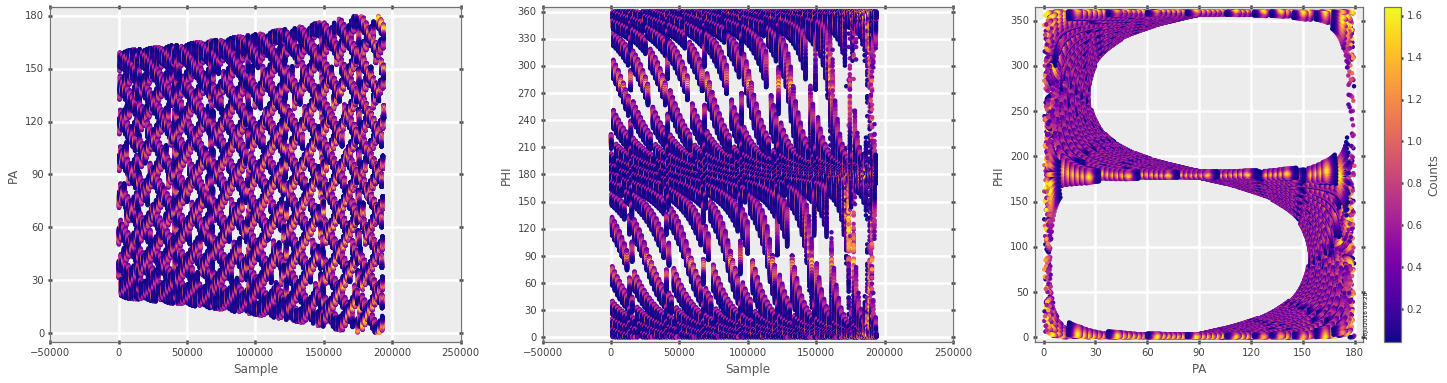

In [124]:
t_ind = 100
energy = 32

t_inds = np.arange(100, 201, 1)

len_times = len(t_inds)

t_len = np.product((len_times, N_SECTORS, 11-1, 13-1))

ans = np.empty((t_len, 4), dtype=float)
ans.fill(0)

print('ans.shape', ans.shape)  # this is (index, vars)


ans = [] # TODO figure out how to index this right

counter = 0
tb.progressbar(0,1,len_times)
for ii, t_ind in enumerate(t_inds):
    tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])
    tb.progressbar(ii+1,1, len_times, text=tm.isoformat())
    for jj, s_ind in enumerate(np.arange(16)):


        PA, PHI, counts, weights = compute_PA(100, magInterp_Ele[t_ind, s_ind, energy], lib, 
                                              polar_range=(-3.5, 3.5), azi_range=(-4, 4),
                                              n_polar=11, n_azi=13)
        if counter == 0:
            ans = np.vstack((PA, PHI, counts, weights)).T
        else:
            ans = np.vstack((ans, np.vstack((PA, PHI, counts, weights)).T))
            
        counter += 1


ans = np.asarray(ans)
        
    
print('ans.shape', ans.shape)  # this is (index, vars)


make_plots2(ans)
# make_plots(ans)
# ans = np.vstack((PA_out, PHI_out, ans[:,0,:], ans[:,1,:]))
# print('PA', PA.shape)
# print('PHI', PHI.shape)
# print('counts', counts.shape)
# print('weights', weights.shape)


Collapse the plot down to a PA distribution. It should be flat as all the inputs are 100

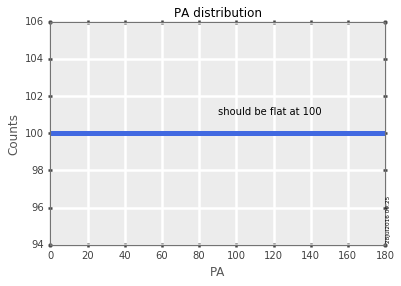

In [123]:
CNTS = ans[:,2]/ans[:,3]
plt.plot(ans[:,0], CNTS, '.')
plt.xlabel('PA')
plt.ylabel('Counts')
plt.title("PA distribution")
plt.text(90, 101, 'should be flat at 100')
spp.timestamp()
